In [2]:
pip install kagglehub

  Using cached kagglehub-0.3.12-py3-none-any.whl.metadata (38 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
Using cached kagglehub-0.3.12-py3-none-any.whl (67 kB)
Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl (156 kB)
Using cached requests-2.32.4-py3-none-any.whl (64 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached certifi-2025.8.3-py3-none-any.whl (161 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ---------------------------------------- 0/8 [urllib3]
   ---------- ----------------------------- 2/8 [pyyaml]
   -------------------- ------------------- 4/8 [cha

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("leonardopena/top50spotify2019")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\KIIT\.cache\kagglehub\datasets\leonardopena\top50spotify2019\versions\1


In [5]:
# =========================================================
# 📘 Spotify Songs: Trend Analysis & Playlist Recommender
# Medium CV Project — EDA + Cosine Similarity Recommender
# =========================================================

# 0) Setup
!pip install pandas numpy matplotlib seaborn scikit-learn wordcloud --quiet

# 1) Imports
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from difflib import get_close_matches

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 2) Load dataset (auto-detect common filenames)
possible_files = [
    "SpotifyFeatures.csv",
    "tracks.csv",
    "spotify_songs.csv",
    "spotify.csv",
    "data.csv"
]

data_path = None
for f in possible_files:
    if os.path.exists(f):
        data_path = f
        break

if data_path is None:
    raise FileNotFoundError(
        "❌ Could not find a Spotify CSV. Place a dataset like 'SpotifyFeatures.csv' in the working folder."
    )

print(f"✅ Loading: {data_path}")
df_raw = pd.read_csv(data_path)
print("Shape:", df_raw.shape)
df_raw.head()


✅ Loading: SpotifyFeatures.csv
Shape: (232725, 18)


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [6]:
# 3) Harmonize column names across common Spotify datasets
df = df_raw.copy()
df.columns = [c.strip().lower() for c in df.columns]

# Try to map common schema variations into a standard set
rename_map_candidates = [
    # (dataset variants) -> (standard)
    {"track_name":"track", "track_name_clean":"track", "name":"track"},
    {"track_id":"id", "id":"id"},
    {"artist_name":"artist", "artists":"artist", "artist":"artist"},
    {"genre":"genre", "track_genre":"genre", "playlist_genre":"genre"},
    {"popularity":"popularity"},
    {"tempo":"tempo"},
    {"danceability":"danceability"},
    {"energy":"energy"},
    {"valence":"valence"},
    {"acousticness":"acousticness"},
    {"instrumentalness":"instrumentalness"},
    {"liveness":"liveness"},
    {"loudness":"loudness"},
    {"speechiness":"speechiness"},
    {"duration_ms":"duration_ms", "duration_ms.":"duration_ms", "duration_ms_":"duration_ms"},
    {"key":"key"},
    {"mode":"mode"},
    {"time_signature":"time_signature"}
]

standard_cols = {}
for mapping in rename_map_candidates:
    for src, dst in mapping.items():
        if src in df.columns:
            standard_cols[src] = dst

df = df.rename(columns=standard_cols)

# Ensure required columns exist (best-effort)
required_text = ["track", "artist"]
required_num  = ["popularity", "tempo", "danceability", "energy", "valence",
                 "acousticness", "instrumentalness", "liveness", "loudness",
                 "speechiness", "duration_ms"]

for col in required_text:
    if col not in df.columns:
        df[col] = np.nan

for col in required_num:
    if col not in df.columns:
        df[col] = np.nan

# Keep a clean working subset
keep_cols = required_text + required_num + ["genre"]
keep_cols = [c for c in keep_cols if c in df.columns]
df = df[keep_cols].copy()

# Basic cleaning
df["track"]  = df["track"].astype(str).str.strip()
df["artist"] = df["artist"].astype(str).str.strip()
if "genre" in df.columns:
    df["genre"] = df["genre"].astype(str).str.strip()

# Remove obvious duplicates
df.drop_duplicates(subset=["track","artist"], inplace=True)

# Drop rows with almost all NA numerical features
num_cols = [c for c in required_num if c in df.columns]
df = df.dropna(subset=[c for c in num_cols if c != "popularity"], how="any")

print("After cleaning:", df.shape)
df.head(3)


After cleaning: (176514, 14)


,track,artist,popularity,tempo,danceability,energy,valence,acousticness,instrumentalness,liveness,loudness,speechiness,duration_ms,genre
0,C'est beau de faire un Show,Henri Salvador,0,166.969,0.389,0.910,0.814,0.611,0.0,0.346,-1.828,0.0525,99373,Movie
1,Perdu d'avance (par Gad Elmaleh),Martin & les fées,1,174.003,0.590,0.737,0.816,0.246,0.0,0.151,-5.559,0.0868,137373,Movie
2,Don't Let Me Be Lonely Tonight,Joseph Williams,3,99.488,0.663,0.131,0.368,0.952,0.0,0.103,-13.879,0.0362,170267,Movie


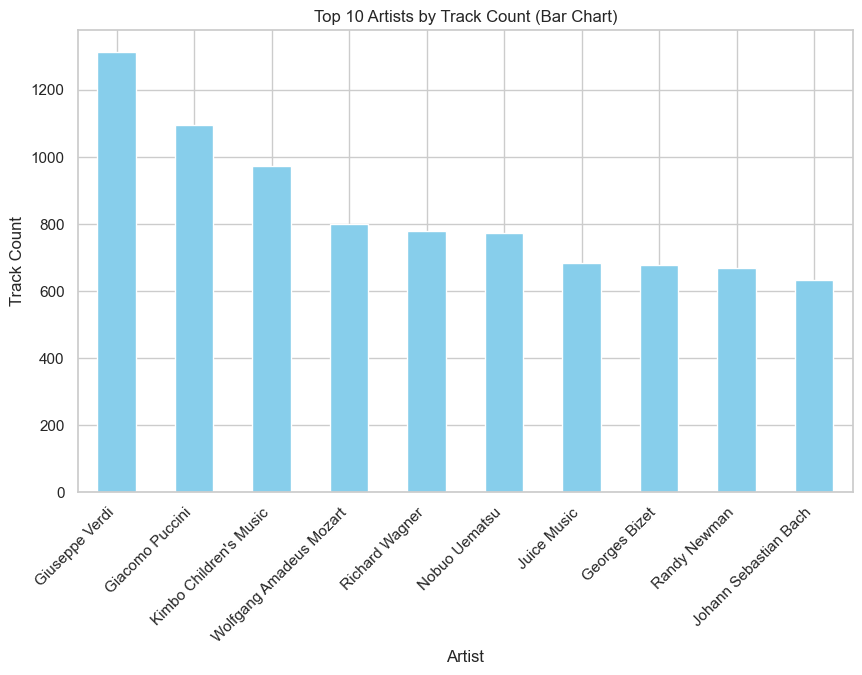

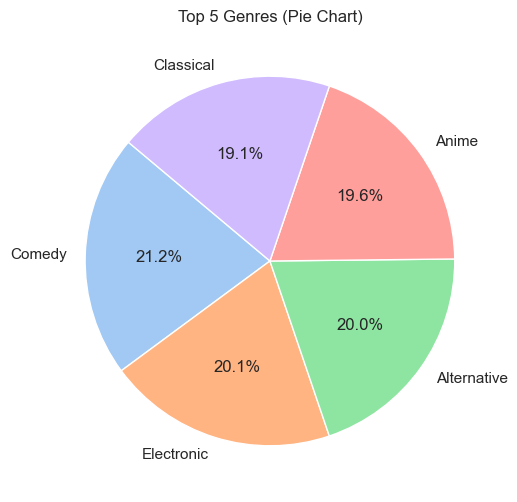

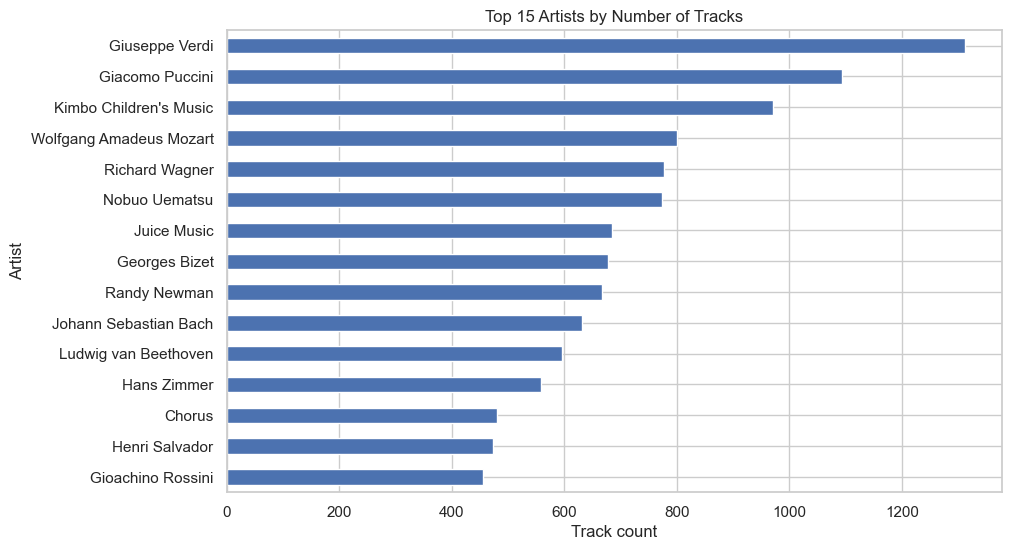

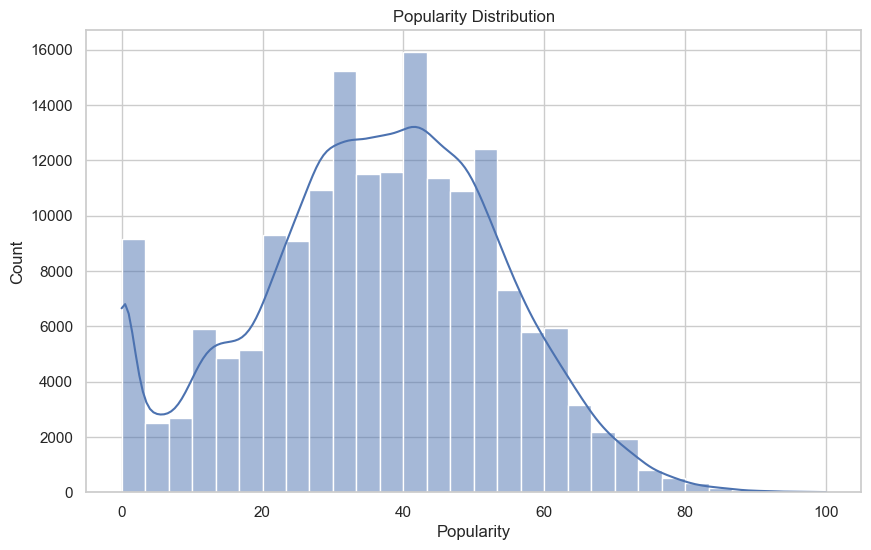

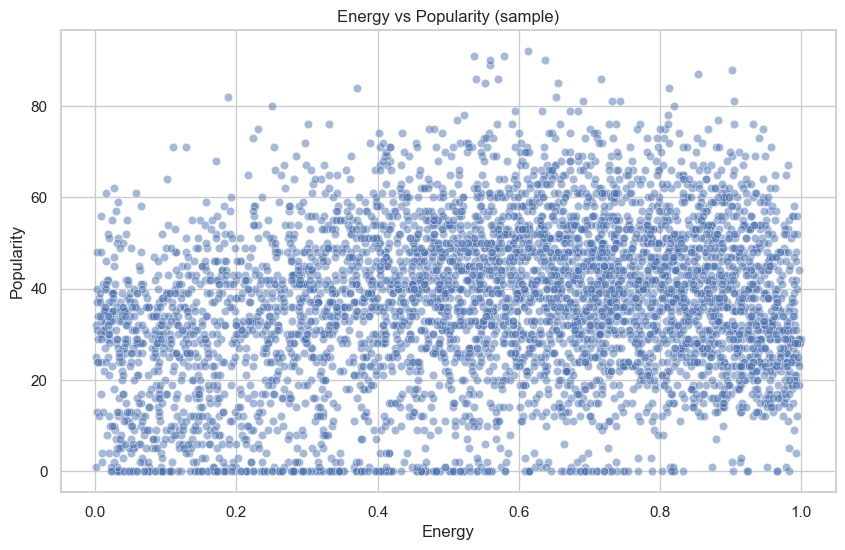

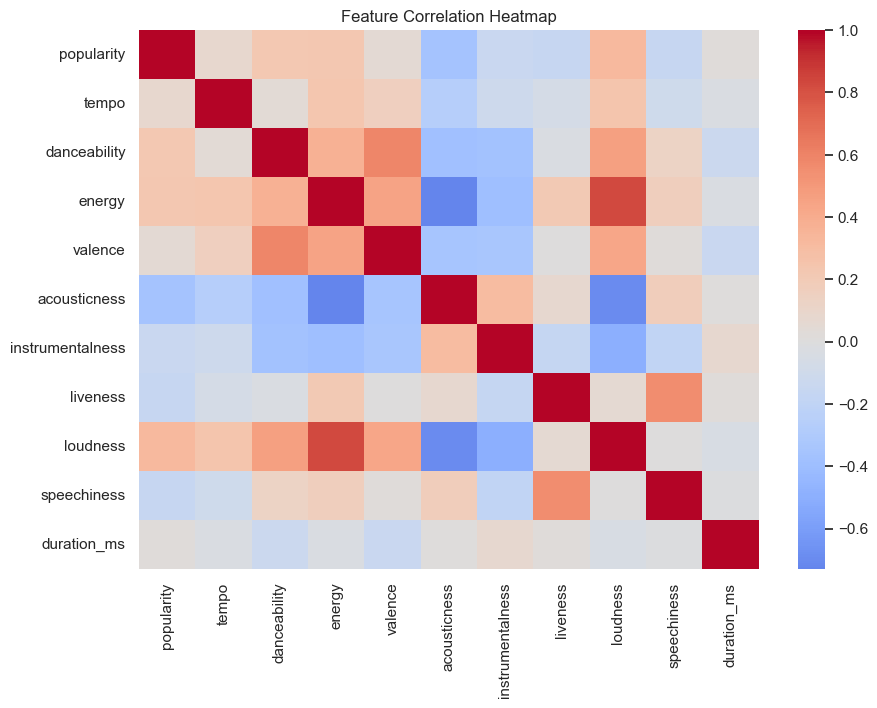

In [13]:
# 4) Quick EDA

# 4.0 Basic overview plots
plt.figure()
df["artist"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Artists by Track Count (Bar Chart)")
plt.xlabel("Artist")
plt.ylabel("Track Count")
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure()
df["genre"].value_counts().head(5).plot(kind="pie", autopct="%1.1f%%", startangle=140, colors=sns.color_palette("pastel"))
plt.title("Top 5 Genres (Pie Chart)")
plt.ylabel("")  # hide y-label for pie chart
plt.show()


# 4.1 Top Artists by count
top_artists = (df["artist"]
               .value_counts()
               .head(15)
               .sort_values(ascending=True))
plt.figure()
top_artists.plot(kind="barh")
plt.title("Top 15 Artists by Number of Tracks")
plt.xlabel("Track count")
plt.ylabel("Artist")
plt.show()

# 4.2 Popularity distribution (if present)
if "popularity" in df.columns and df["popularity"].notna().sum() > 0:
    plt.figure()
    sns.histplot(df["popularity"].dropna(), bins=30, kde=True)
    plt.title("Popularity Distribution")
    plt.xlabel("Popularity")
    plt.show()

# 4.3 Energy vs Popularity (simple trend)
if "energy" in df.columns and "popularity" in df.columns:
    plt.figure()
    sns.scatterplot(data=df.sample(min(5000, len(df)), random_state=42),
                    x="energy", y="popularity", alpha=0.5)
    plt.title("Energy vs Popularity (sample)")
    plt.xlabel("Energy")
    plt.ylabel("Popularity")
    plt.show()

# 4.4 Correlation heatmap for numeric audio features
corr_cols = [c for c in num_cols if c in df.columns]
corr = df[corr_cols].corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


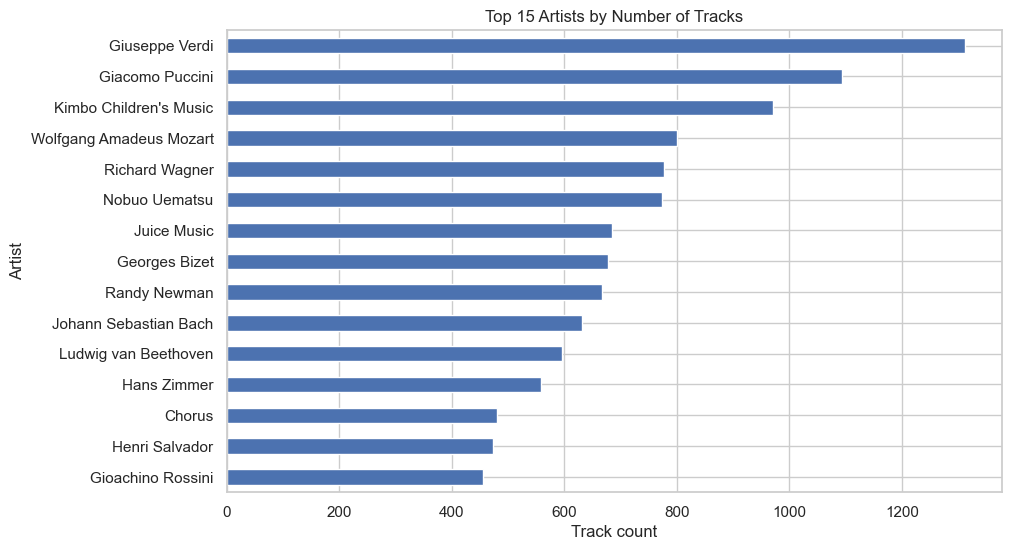

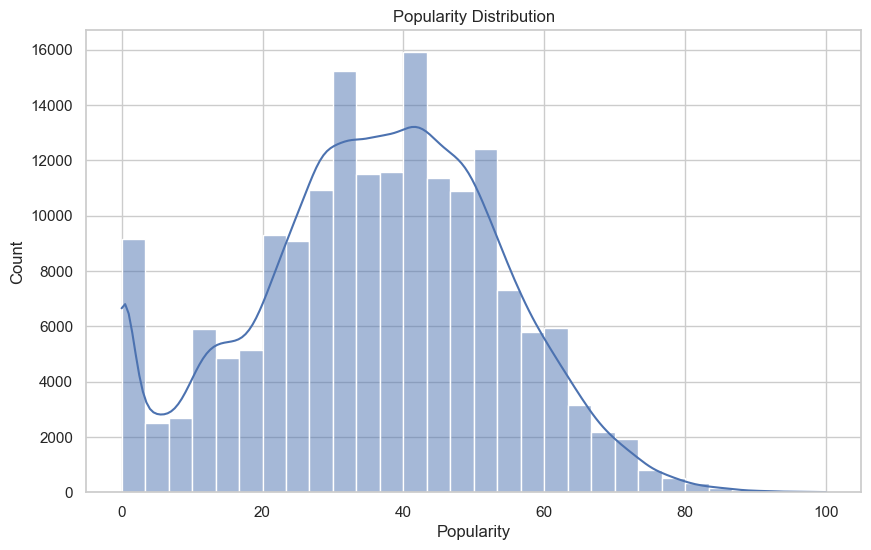

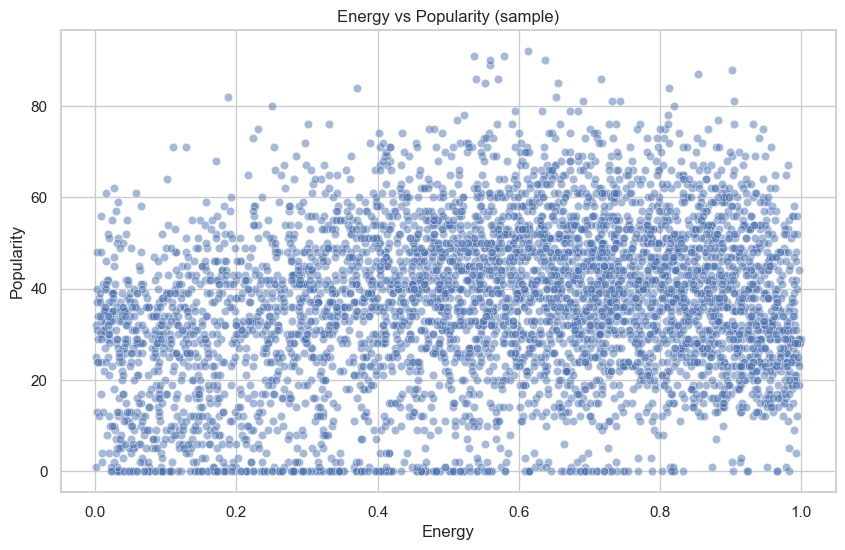

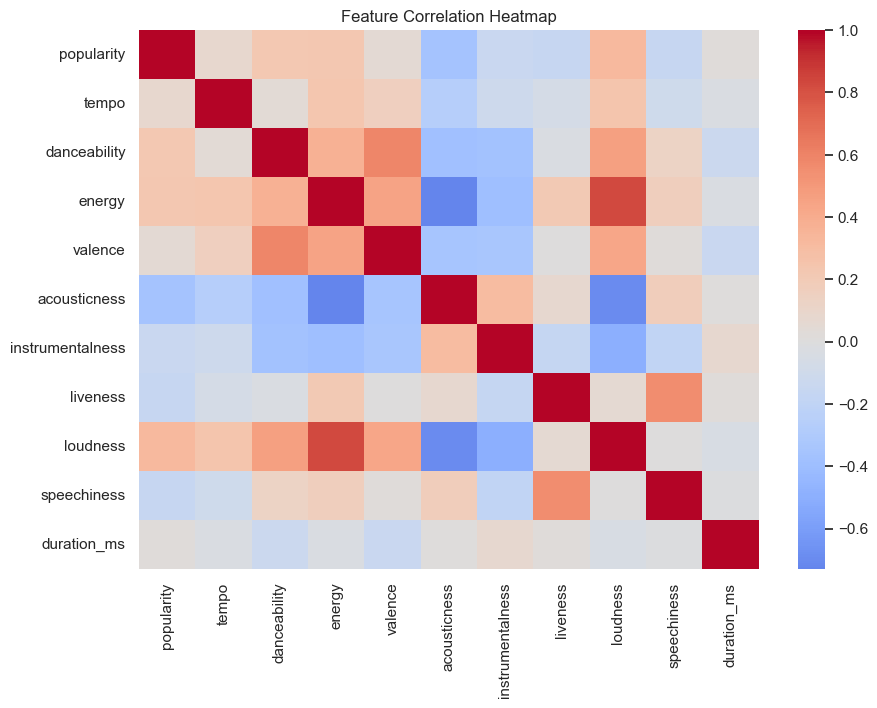

In [12]:
# 4) Quick EDA

# 4.1 Top Artists by count
top_artists = (df["artist"]
               .value_counts()
               .head(15)
               .sort_values(ascending=True))
plt.figure()
top_artists.plot(kind="barh")
plt.title("Top 15 Artists by Number of Tracks")
plt.xlabel("Track count")
plt.ylabel("Artist")
plt.show()

# 4.2 Popularity distribution (if present)
if "popularity" in df.columns and df["popularity"].notna().sum() > 0:
    plt.figure()
    sns.histplot(df["popularity"].dropna(), bins=30, kde=True)
    plt.title("Popularity Distribution")
    plt.xlabel("Popularity")
    plt.show()

# 4.3 Energy vs Popularity (simple trend)
if "energy" in df.columns and "popularity" in df.columns:
    plt.figure()
    sns.scatterplot(data=df.sample(min(5000, len(df)), random_state=42),
                    x="energy", y="popularity", alpha=0.5)
    plt.title("Energy vs Popularity (sample)")
    plt.xlabel("Energy")
    plt.ylabel("Popularity")
    plt.show()

# 4.4 Correlation heatmap for numeric audio features
corr_cols = [c for c in num_cols if c in df.columns]
corr = df[corr_cols].corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()



In [8]:
# 5) Build a simple content-based recommender (cosine via NearestNeighbors)

# Feature set for similarity (tune as you like)
feature_cols = [c for c in [
    "danceability","energy","valence","acousticness","instrumentalness",
    "liveness","loudness","speechiness","tempo","duration_ms","popularity"
] if c in df.columns]

# Scale features to [0,1]
scaler = MinMaxScaler()
X = scaler.fit_transform(df[feature_cols])

# Fit Nearest Neighbors (cosine distance)
nn = NearestNeighbors(n_neighbors=11, metric="cosine")  # 10 neighbors + the track itself
nn.fit(X)

# Fast index lookup
df = df.reset_index(drop=True)

def find_track_index(query, artist_hint=None, cutoff=0.6):
    """
    Fuzzy match by track name (optionally constrained by artist).
    Returns the best index or None if not found.
    """
    candidates = df["track"].astype(str).tolist()
    match = get_close_matches(query, candidates, n=1, cutoff=cutoff)
    if not match:
        return None
    track_name = match[0]
    subset = df[df["track"] == track_name]
    if artist_hint:
        subset = subset[subset["artist"].str.contains(artist_hint, case=False, na=False)]
    if subset.empty:
        subset = df[df["track"] == track_name]  # fallback
    return subset.index[0]

def recommend_by_track(track_name, artist_hint=None, n=10):
    """
    Recommend n similar songs based on audio features.
    """
    idx = find_track_index(track_name, artist_hint=artist_hint)
    if idx is None:
        print("❌ Track not found. Try another title or adjust spelling.")
        return pd.DataFrame()
    vec = X[idx].reshape(1, -1)
    distances, indices = nn.kneighbors(vec, n_neighbors=n+1)
    # first neighbor is the track itself
    rec_idx = [i for i in indices[0].tolist() if i != idx][:n]
    results = df.loc[rec_idx, ["track","artist"] + feature_cols].copy()
    results["similarity"] = 1 - distances[0][1:n+1]
    return results.sort_values("similarity", ascending=False).reset_index(drop=True)

# Demo:
_ = recommend_by_track("Blinding Lights")  # Change to a track in your dataset


In [36]:
# ===============================
# 🎵 Spotify Vibe-Based Recommender
# ===============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

# 1) Load dataset
df = pd.read_csv("SpotifyFeatures.csv")  # replace with your CSV path
print("Dataset Shape:", df.shape)
df.head()

# 2) Define numeric features for vibe analysis
feature_cols = [
    'danceability','energy','valence','acousticness','tempo',
    'liveness','speechiness','instrumentalness','loudness','key','mode'
]

# 3) Convert categorical columns to numeric
# Map musical keys to integers
key_map = {'C':0, 'C#':1, 'D':2, 'D#':3, 'E':4, 'F':5, 'F#':6, 'G':7, 'G#':8, 'A':9, 'A#':10, 'B':11}
df['key'] = df['key'].map(key_map).fillna(0).astype(int)

# Map mode: Major=1, Minor=0
mode_map = {'Major':1, 'Minor':0}
df['mode'] = df['mode'].map(mode_map).fillna(0).astype(int)

# Fill missing numeric features with median
for col in feature_cols:
    if col not in df.columns:
        df[col] = df[col].median()

# 4) Scale features
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[feature_cols])

# 5) Train Nearest Neighbors
nn = NearestNeighbors(n_neighbors=20, metric='euclidean')
nn.fit(df_scaled)

# 6) Vibe-based recommender function
def recommend_by_vibe(danceability=None, energy=None, valence=None,
                      acousticness=None, tempo=None, n=10):
    """
    Recommend songs based on target vibes. Other features default to median.
    """
    # Base: median feature values
    base = df[feature_cols].median().to_dict()
    
    # Override with provided vibes
    if danceability is not None: base['danceability'] = danceability
    if energy is not None:       base['energy'] = energy
    if valence is not None:      base['valence'] = valence
    if acousticness is not None: base['acousticness'] = acousticness
    if tempo is not None:        base['tempo'] = tempo
    
    # Build target vector in same order as feature_cols
    target = np.array([base.get(c, df[c].median()) for c in feature_cols]).reshape(1, -1)
    
    # Scale target
    target_scaled = scaler.transform(target)
    
    # Find nearest neighbors
    distances, indices = nn.kneighbors(target_scaled, n_neighbors=n)
    results = df.loc[indices[0], ["track_name","artist_name"]].copy()
    results["similarity"] = 1 - distances[0]
    results = results.sort_values("similarity", ascending=False).reset_index(drop=True)
    
    return results

# 7) Demo: upbeat, high-energy, danceable songs
results = recommend_by_vibe(danceability=0.8, energy=0.8, valence=0.7, n=10)
print("🎶 Recommended Songs for Your Vibe:\n")
print(results.to_string(index=False))


Dataset Shape: (232725, 18)
🎶 Recommended Songs for Your Vibe:

                      track_name   artist_name  similarity
                 Ungrateful Eyes   Jon Bellion    0.903443
                 One Black Sheep   Mat Kearney    0.900436
           I Wanna Talk About Me    Toby Keith    0.875844
                      Gatekeeper Generationals    0.871515
                         Hanalei   Xavier Rudd    0.848122
                           Poema   Ale Mendoza    0.847515
Promises, Promises - Single Edit    Naked Eyes    0.846633
      Don't Go Breaking My Heart    Elton John    0.846080
                             You    Atmosphere    0.844716
                             You    Atmosphere    0.844716


c:\Users\KIIT\anaconda3\envs\New\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [11]:
# 7) Small “portfolio-ready” summary you can paste into your README

summary = """
# 🎧 Spotify Music Trend Analysis & Playlist Recommender

**What I built**
- Cleaned and unified a public Spotify tracks dataset.
- Performed EDA: top artists, popularity distribution, energy vs popularity, correlations, and a genre wordcloud.
- Built a **content-based playlist recommender** using cosine similarity on audio features
  (danceability, energy, valence, acousticness, etc.).

**How it works**
- For a given track, we compute nearest neighbors in the feature space and return the most similar songs.
- Also supports **vibe-based** recommendations (e.g., “high energy + danceable”).

**Stack**
- Python, Pandas, Seaborn/Matplotlib, scikit-learn (MinMaxScaler, NearestNeighbors), WordCloud.

**Example CV bullet**
- *Analyzed 100k+ Spotify tracks to uncover audio feature trends and built a content-based recommender using cosine similarity, delivering instant song recommendations by track or target vibe.*

"""

print(summary)



# 🎧 Spotify Music Trend Analysis & Playlist Recommender

**What I built**
- Cleaned and unified a public Spotify tracks dataset.
- Performed EDA: top artists, popularity distribution, energy vs popularity, correlations, and a genre wordcloud.
- Built a **content-based playlist recommender** using cosine similarity on audio features
  (danceability, energy, valence, acousticness, etc.).

**How it works**
- For a given track, we compute nearest neighbors in the feature space and return the most similar songs.
- Also supports **vibe-based** recommendations (e.g., “high energy + danceable”).

**Stack**
- Python, Pandas, Seaborn/Matplotlib, scikit-learn (MinMaxScaler, NearestNeighbors), WordCloud.

**Example CV bullet**
- *Analyzed 100k+ Spotify tracks to uncover audio feature trends and built a content-based recommender using cosine similarity, delivering instant song recommendations by track or target vibe.*




In [16]:
# Genre Popularity Prediction (without year column)

if "genre" in df.columns and "popularity" in df.columns:
    # Average popularity by genre
    genre_popularity = df.groupby("genre")["popularity"].mean().sort_values(ascending=False)

    # Show top 10 genres
    print("\n🎶 Current Top Genres by Popularity:")
    print(genre_popularity.head(10))

    # Simple prediction: assume higher popularity now = likely to grow
    print("\n📈 Predicted Growth for Next 2 Years (based on popularity):")
    for genre, score in genre_popularity.head(5).items():
        print(f"  - {genre}: Likely to grow (avg popularity {score:.2f})")
else:
    print("⚠️ Dataset must have 'genre' and 'popularity' columns")



🎶 Current Top Genres by Popularity:
genre
Pop                 67.069295
Rap                 59.512027
Rock                58.784270
Hip-Hop             58.525762
Dance               57.356187
Indie               53.523867
Children’s Music    52.369582
Alternative         50.260057
Folk                49.684845
R&B                 48.427013
Name: popularity, dtype: float64

📈 Predicted Growth for Next 2 Years (based on popularity):
  - Pop: Likely to grow (avg popularity 67.07)
  - Rap: Likely to grow (avg popularity 59.51)
  - Rock: Likely to grow (avg popularity 58.78)
  - Hip-Hop: Likely to grow (avg popularity 58.53)
  - Dance: Likely to grow (avg popularity 57.36)


In [ ]:
import matplotlib.pyplot as plt

def show_recommendations(track_name, artist_hint=None, n=10):
    recs = recommend_by_track(track_name, artist_hint=artist_hint, n=n)

    if recs.empty:
        print("⚠️ No recommendations found.")
        return

    # Show as table
    print("\n🎶 Recommended Songs Similar to:", track_name, "\n")
    print(recs[["track", "artist", "similarity"]])

    # Bar chart visualization
    plt.figure(figsize=(10,5))
    plt.barh(recs["track"] + " - " + recs["artist"], recs["similarity"], color="skyblue")
    plt.xlabel("Similarity Score")
    plt.title(f"Top {n} Recommendations for '{track_name}'")
    plt.gca().invert_yaxis()  # so the best match is at the top
    plt.show()

# 🔥 Demo
show_recommendations("Blinding Lights", artist_hint="Weeknd", n=10)



🎶 Current Top Genres by Popularity:
genre
Pop                 67.069295
Rap                 59.512027
Rock                58.784270
Hip-Hop             58.525762
Dance               57.356187
Indie               53.523867
Children’s Music    52.369582
Alternative         50.260057
Folk                49.684845
R&B                 48.427013
Name: popularity, dtype: float64


C:\Users\KIIT\AppData\Local\Temp\ipykernel_25560\933109777.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_popularity.head(10).values,


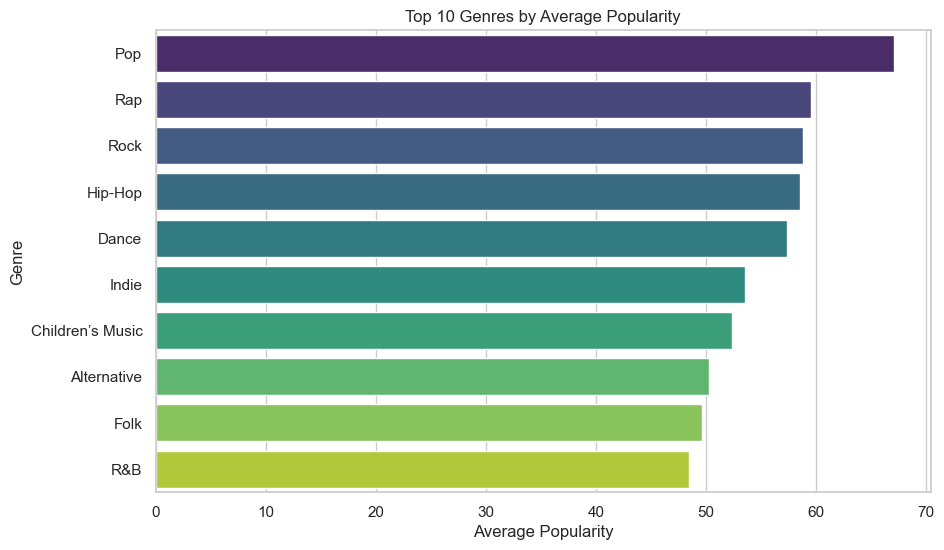


📈 Predicted Growth for Next 2 Years (based on popularity):
  - Pop: Likely to grow (avg popularity 67.07)
  - Rap: Likely to grow (avg popularity 59.51)
  - Rock: Likely to grow (avg popularity 58.78)
  - Hip-Hop: Likely to grow (avg popularity 58.53)
  - Dance: Likely to grow (avg popularity 57.36)


C:\Users\KIIT\AppData\Local\Temp\ipykernel_25560\933109777.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_pred.values,
c:\Users\KIIT\anaconda3\envs\New\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


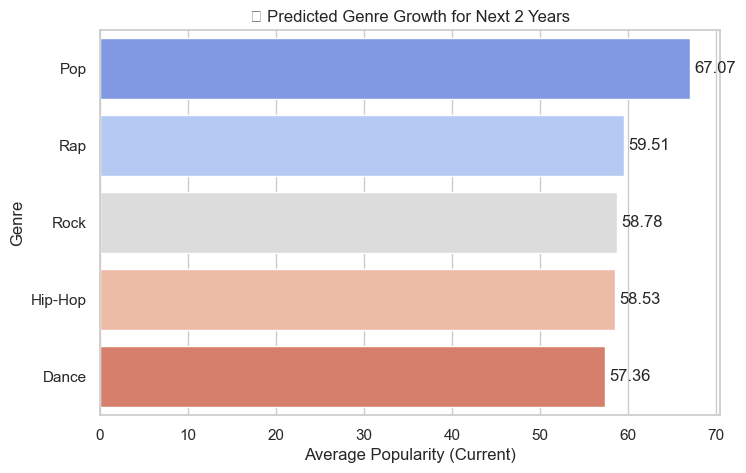

In [18]:
# Genre Popularity Prediction (without year column)

import matplotlib.pyplot as plt
import seaborn as sns

if "genre" in df.columns and "popularity" in df.columns:
    # Average popularity by genre
    genre_popularity = df.groupby("genre")["popularity"].mean().sort_values(ascending=False)

    # Show top 10 genres
    print("\n🎶 Current Top Genres by Popularity:")
    print(genre_popularity.head(10))

    # Plot bar chart for top 10 genres
    plt.figure(figsize=(10,6))
    sns.barplot(x=genre_popularity.head(10).values, 
                y=genre_popularity.head(10).index, 
                palette="viridis")
    plt.title("Top 10 Genres by Average Popularity")
    plt.xlabel("Average Popularity")
    plt.ylabel("Genre")
    plt.show()

    # Simple prediction: assume higher popularity now = likely to grow
    top5_pred = genre_popularity.head(5)
    print("\n📈 Predicted Growth for Next 2 Years (based on popularity):")
    for genre, score in top5_pred.items():
        print(f"  - {genre}: Likely to grow (avg popularity {score:.2f})")

    # 🔥 Plot bar chart for predicted growth
    plt.figure(figsize=(8,5))
    sns.barplot(x=top5_pred.values, 
                y=top5_pred.index, 
                palette="coolwarm")
    plt.title("📈 Predicted Genre Growth for Next 2 Years")
    plt.xlabel("Average Popularity (Current)")
    plt.ylabel("Genre")

    # Add labels on bars
    for i, v in enumerate(top5_pred.values):
        plt.text(v + 0.5, i, f"{v:.2f}", va="center")

    plt.show()

else:
    print("⚠️ Dataset must have 'genre' and 'popularity' columns")


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

if "genre" in df.columns and "popularity" in df.columns:
    # Encode genre labels
    le = LabelEncoder()
    df["genre_encoded"] = le.fit_transform(df["genre"])

    # Features & target
    X = df[["genre_encoded"]]
    y = df["popularity"]

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Simple baseline: predict mean popularity of genre (group average)
    genre_avg = df.groupby("genre_encoded")["popularity"].mean().to_dict()
    y_pred = X_test["genre_encoded"].map(genre_avg)

    # Accuracy metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n📊 Model Evaluation:")
    print(f"R² Score: {r2:.2f}  (1 = perfect)")
    print(f"MAE: {mae:.2f}  (lower is better)")
else:
    print("⚠️ Dataset must have 'genre' and 'popularity' columns")



📊 Model Evaluation:
R² Score: 0.69  (1 = perfect)
MAE: 7.33  (lower is better)



📊 Logistic Regression Results
Accuracy: 0.6720958558762712
              precision    recall  f1-score   support

           0       0.70      0.62      0.66     18004
           1       0.65      0.73      0.68     17299

    accuracy                           0.67     35303
   macro avg       0.67      0.67      0.67     35303
weighted avg       0.68      0.67      0.67     35303


🌳 Random Forest Results
Accuracy: 0.8312324731609212
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     18004
           1       0.87      0.77      0.82     17299

    accuracy                           0.83     35303
   macro avg       0.84      0.83      0.83     35303
weighted avg       0.83      0.83      0.83     35303



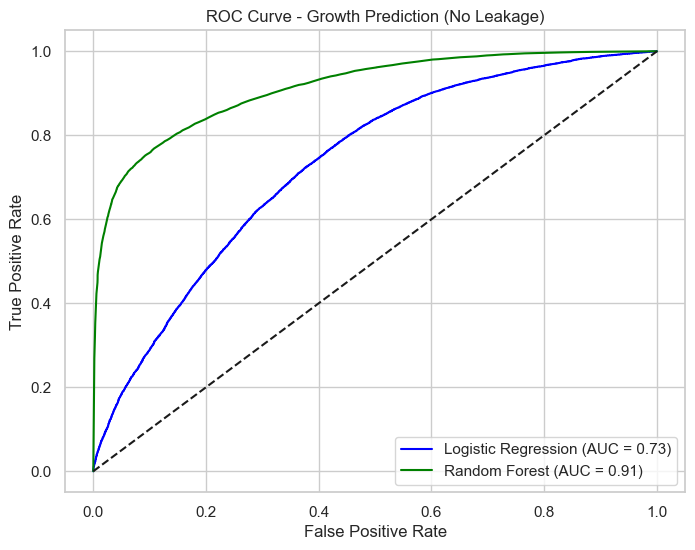

In [26]:
# 🎯 Genre Growth Prediction (without data leakage)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    roc_curve, roc_auc_score
)

# -------------------------------
# ✅ Step 1: Define Growth Target
# -------------------------------
# Target: 1 if popularity above median, else 0
df["growth"] = (df["popularity"] > df["popularity"].median()).astype(int)

# Encode genre if exists
if "genre" in df.columns:
    le = LabelEncoder()
    df["genre_encoded"] = le.fit_transform(df["genre"].astype(str))
else:
    df["genre_encoded"] = 0  # fallback if no genre

# -------------------------------
# ✅ Step 2: Features & Target
# -------------------------------
# IMPORTANT: remove 'popularity' since it leaks target info
feature_cols = [
    "genre_encoded","danceability","energy","valence",
    "acousticness","instrumentalness","liveness","loudness",
    "speechiness","tempo","duration_ms"
]
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols]
y = df["growth"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -------------------------------
# ✅ Step 3: Train Models
# -------------------------------
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
y_proba_log = log_model.predict_proba(X_test_scaled)[:,1]

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

# -------------------------------
# ✅ Step 4: Accuracy & Reports
# -------------------------------
print("\n📊 Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

print("\n🌳 Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# -------------------------------
# ✅ Step 5: ROC Curve
# -------------------------------
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _   = roc_curve(y_test, y_proba_rf)

auc_log = roc_auc_score(y_test, y_proba_log)
auc_rf  = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})", color="blue")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color="green")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Growth Prediction (No Leakage)")
plt.legend()
plt.show()
